<a href="https://colab.research.google.com/github/21m1n/Stock-Movement-Prediction-Using-News-Headlines/blob/main/Using_News_Headlines_to_Predict_Stock_Movement_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict DJIA Stock Movement Using Reddit News Headlines 

# Introduction

## Objective

The purpose of this project is to explore the probability of using most discussed world news headlines to predict the selected stock movement (up or down). 

## About the Dataset 

The original dataset is downloaded from [Kaggle.com](https://www.kaggle.com/aaron7sun/stocknews/notebooks). It consists of 1989 observations: top 25 daily news headlines as well as the Dow Jones Industrial Average (DJIA) movement index from Auguest 8, 2008 to July 1, 2016. The news headlines are scraped from **World News** *subreddit* on Reddit.com, and the DJIA movement is directly obtained from Yahoo Finance. 

Reddit is an online community where users share their opinions about various subjects, from politics, science to daily lives. In the World News subreddit, users discuss the latest happenings around the world outside the United States. 

Dow Jones Industrial Average (DJIA) is considered to be one of the representative measures of the US stock market besides S&P500, . It takes the sum of the largest 30 listed companies stock prices and divide it by a normalization factor. DIJA includes companies from various industries in the United States, namely Apple, 3M, Goldman Sachs and so on. 





# Methodologies

First, text preprocessing is performed, including text normalization, removing special tags, removing punctuation, removing digits and so on. Concentrations, stop words, text stemming and lemmatization are not performed as it is found that without these steps, the prediction result is higher. Then, the dataset is split into training set (before 2015-01-01) and testing set (after 2014-12-31) based on the dates, which is roughly 80 to 20 ratio. Some simple EDA is performed as well, such as world clouds and topic modeling. Next, the processed text headlines are combined into one blob and converted into numeric representation using three techniques: count vectorizer, Tfidf, and GloVe embeddings. Last, both machine learning and deep learning techniques are applied.   

The process is summarised in the following flowchart. 

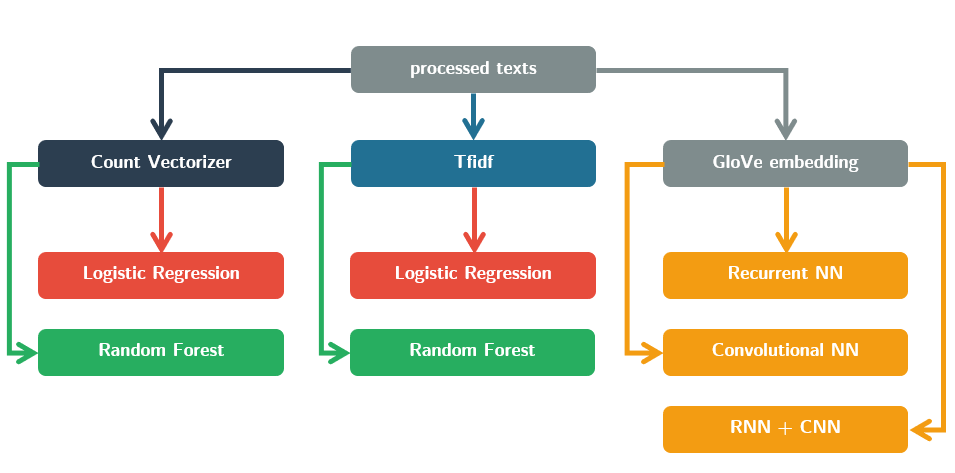

# Preliminaries

The purpose of this section is to:
1. import necessary libraries 
2. define customized functions

In [ ]:
# install `contractions` library
!pip install contractions

# install `vaderSentiment` library
!pip install vaderSentiment 

     |████████████████████████████████| 245kB 6.7MB/s 
     |████████████████████████████████| 327kB 10.4MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp36-cp36m-linux_x86_64.whl size=84328 sha256=74dace7c8f6f06497c1dd6d2c30faf562e09faac6362b952ed690454b04bfc7c
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick
     |████████████████████████████████| 133kB 8.6MB/s 


In [ ]:
# mount google drive to use assocaited files 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np

# libraries for text preprocessing
import re
import string
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from contractions import fix

# for EDA
from wordcloud import WordCloud
from gensim.corpora import Dictionary
from sklearn.decomposition import LatentDirichletAllocation


# for modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# set seed for reproducbility
np.random.seed(42)
random_state = 42

In [ ]:
# download stopwords package from nltk 
nltk.download("stopwords")

nltk.download('punkt')

# define the stopWords vocab
stopWords = stopwords.words("english")
stopWords.extend(["say", "says", "said", "one", "two", "three"])

# define the stemmer 
stemmer = PorterStemmer()

# define functions 

def getCleanText(text):
  '''
  this function does the following to input text:
  - normalization (convert to lowercase)
  - remove special tags ("b, 'b)
  - fix contractions (e.g. won'b -> will not)
  - remove text within square brackets 
  - remove punctuation
  - remove numbers
  '''
  text = text.lower()
  text = re.sub('(b\")', '', text)
  text = re.sub("(b\')", "", text)
  # text = fix(text)
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\w*\d\w*', '', text)

  return text


def removeStopWords(text):
  '''
  this function removes stop words (from 'ntlk` library) from texts
  '''
  return " ".join([word for word in text.split() if word not in (stopWords)])

def stemWords(text):
  '''
  this function returns a list of words that are stemmed 
  '''
  return " ".join([stemmer.stem(word) for word in text.split()])

def plot_roc(X_pred, y_train, y_pred, y_test):
  '''
  this function plots the roc curves for both training and testing dataset
  '''
  fpr_t, tpr_t, _  = roc_curve(y_train, X_pred)
  fpr,   tpr,   _  = roc_curve(y_test, y_pred)

  plt.figure()
  plt.plot(fpr_t, tpr_t, "mediumseagreen")
  plt.plot(fpr, tpr, "red")
  plt.plot([0, 1], [0, 1], "gray", linestyle = "--")
  plt.legend(["train", "test"])
  plt.title("ROC Curve")
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.show()

def plot_history(history):
  '''
  this function plots the accuracy for both training and testing dataset
  '''
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.legend(["train", "validation"])
  plt.title('Accuracy vs. Epochs')
  plt.xlabel("Epochs")
  plt.ylabel('Accuracy')


  plt.subplot(1, 2, 2)
  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.legend(["train", "validation"])
  plt.title('Loss vs. Epochs')
  plt.xlabel("Epochs")
  plt.ylabel('Loss')

  plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data Pre-processing

The purpose of this section is to:
1. import dataset 
2. perform preliminary analysis 

In [ ]:
# import dataset 

data = pd.read_csv("drive/MyDrive/NLP/data/Combined_News_DJIA.csv")

In [ ]:
# check the dimension of the dataaset 

data.shape

(1989, 27)

In [ ]:
data.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


The dataset contains 1989 observations (rows) and 27 columns, of which 25 are features (news headlines).

In [ ]:
data.describe()

,Label
count,1989.000000
mean,0.535445
std,0.498867
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
# check column names 
data.columns

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25'],
      dtype='object')

In [ ]:
# check missing values 
data.isnull().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
dtype: int64

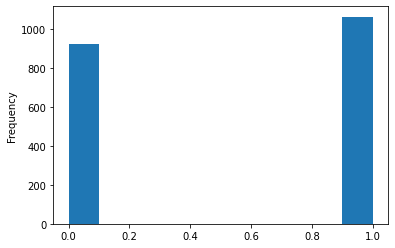

In [ ]:
# check if the labels are balanced
data["Label"].plot.hist()

In [ ]:
data.iloc[1, :]

Date                                            2008-08-11
Label                                                    1
Top1     b'Why wont America and Nato help us? If they w...
Top2           b'Bush puts foot down on Georgian conflict'
Top3     b"Jewish Georgian minister: Thanks to Israeli ...
Top4     b'Georgian army flees in disarray as Russians ...
Top5         b"Olympic opening ceremony fireworks 'faked'"
Top6     b'What were the Mossad with fraudulent New Zea...
Top7     b'Russia angered by Israeli military sale to G...
Top8     b'An American citizen living in S.Ossetia blam...
Top9     b'Welcome To World War IV! Now In High Definit...
Top10    b"Georgia's move, a mistake of monumental prop...
Top11    b'Russia presses deeper into Georgia; U.S. say...
Top12    b'Abhinav Bindra wins first ever Individual Ol...
Top13    b' U.S. ship heads for Arctic to define territ...
Top14    b'Drivers in a Jerusalem taxi station threaten...
Top15    b'The French Team is Stunned by Phelps and the.

In [ ]:
# combine 25 headlines into one blob
all_headlines = []

for row in range(0, len(data)):
    all_headlines.append(" ".join(str(x) for x in data.iloc[row, 2:27]))


# join the output with the dataset as a new column 
data["Text"] = all_headlines

In [ ]:
# keep only the necessary columns 
combined_data = data[["Date", "Label", "Text"]]

# clean the texts:
processed_headlines = combined_data["Text"].apply(getCleanText)

# remove stopwords:
# processed_headlines = processed_headlines.apply(removeStopWords)

# join the processed headlines with the dataset 
combined_data["Text"] = processed_headlines

combined_data.head()

,Date,Label,Text
0,2008-08-08,0,georgia downs two russian warplanes as countri...
1,2008-08-11,1,why wont america and nato help us if they wont...
2,2008-08-12,0,remember that adorable who sang at the openin...
3,2008-08-13,0,us refuses israel weapons to attack iran repo...
4,2008-08-14,1,all the experts admit that we should legalise ...


In [ ]:
# split the training and test set:

df_train = combined_data[combined_data["Date"] < "2015-01-01"]
df_test  = combined_data[combined_data["Date"] > "2014-12-31"]

print("training data shape: ", df_train.shape)
print("test data shape: ", df_test.shape)

training data shape:  (1611, 3)
test data shape:  (378, 3)


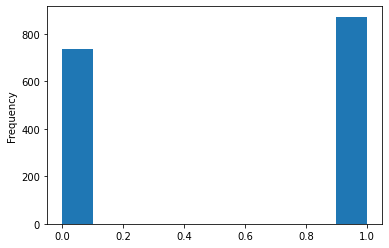

In [ ]:
# check whether the training set label is balanced 
df_train["Label"].plot.hist()

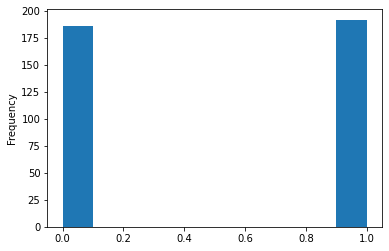

In [ ]:
# check whether testing set is balanced 
df_test["Label"].plot.hist()

In [ ]:
# the lengths of the combined news:
combined_data["lengths"] = combined_data["Text"].apply(len)

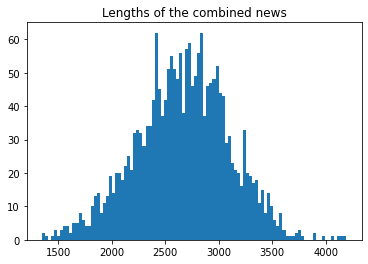

In [ ]:
# histogram of lengths of daily news combined 

plt.hist(combined_data["lengths"], bins=100)
plt.title("Lengths of the combined news")
plt.show()

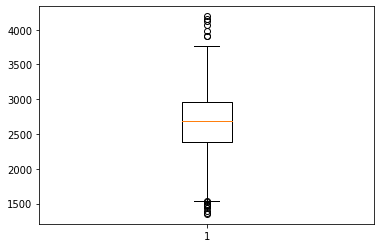

In [ ]:
# boxplot of the combined daily news lengths
plt.boxplot(combined_data["lengths"])
plt.show()

# EDA

In this section, we use wordcloud and topic modeling to explore the dataset. 

In [ ]:
# divide headlines by their labels

pos_news = df_train[df_train["Label"] == 1]["Text"]
neg_news = df_train[df_train["Label"] == 0]["Text"]

## Wordcloud

In [ ]:
# process text
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

# clean the texts 
lemmatizer = WordNetLemmatizer() 

pos_bow = pos_news.apply(removeStopWords)
pos_bow = pos_bow.apply(stemWords)
pos_bow = pos_bow.apply(lemmatizer.lemmatize)

neg_bow = neg_news.apply(removeStopWords)
neg_bow = neg_bow.apply(stemWords)
neg_bow = pos_bow.apply(lemmatizer.lemmatize)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# combine the bag-of-words

pos_wordcloud = ','.join(pos_bow)
neg_wordcloud = ','.join(neg_bow)

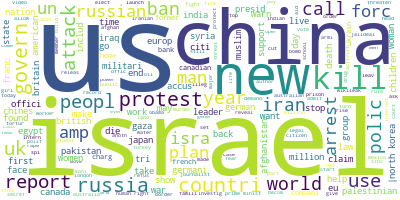

In [ ]:
# generate word cloud for positive news 

wordcloud = WordCloud(background_color='white').generate(pos_wordcloud)
wordcloud.to_image()

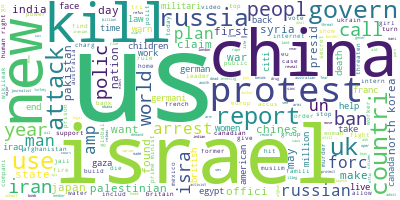

In [ ]:
# generate word cloud for negative news 

wordcloud = WordCloud(background_color='white').generate(neg_wordcloud)
wordcloud.to_image()

From above word clouds, no significant difference can be observed between the positive news (`"Label" = 1`) and negative news (`"Label" = 0`). Both are mainly about political news, as we can observe words such as US, Israel, China, Protest, Kill etc.

## Topic Modeling

Have a look at what these news headlines are mainly about.

In [ ]:
# remove the stopwords and apply stemming, lemmatization to the texts

train_bow = df_train["Text"].apply(removeStopWords)
train_bow = train_bow.apply(stemWords)
train_bow = train_bow.apply(lemmatizer.lemmatize)
# train_bow = train_bow.apply(word_tokenize)

In [ ]:
vectorizer = CountVectorizer()
topic_vec = vectorizer.fit_transform(train_bow)

n_topics = 10

model = LatentDirichletAllocation(n_topics, random_state=42)
model.fit(topic_vec)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

names = vectorizer.get_feature_names()
display_topics(model, names, n_topics)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,us,739.6,protest,238.2,us,107.7,wikileak,119.7,libyan,12.3,us,1577.6,japan,20.4,us,345.6,cricket,5.7,us,450.3
1,new,532.8,israel,206.5,china,97.8,us,117.6,libya,7.9,kill,1079.5,protest,20.3,year,258.6,shoe,5.6,israel,330.2
2,protest,473.7,iran,205.9,nuclear,75.5,assang,96.0,sufi,3.6,year,875.2,egyptian,17.4,kill,231.1,carter,4.7,world,302.7
3,govern,438.2,us,197.3,wikileak,73.2,nsa,89.9,enjoy,3.5,israel,864.3,mubarak,15.2,china,220.6,drift,4.7,north,208.4
4,china,430.5,kill,182.7,bin,71.6,snowden,89.9,bp,3.3,russia,863.9,earthquak,12.8,war,207.4,lankan,4.3,korea,203.0
5,peopl,388.4,china,167.1,japan,70.5,govern,80.6,prefer,3.2,world,803.6,cairo,8.9,govern,202.6,buddhist,4.1,year,199.5
6,polic,381.7,year,157.7,laden,65.3,uk,79.7,jeddah,3.1,polic,750.3,fukushima,8.7,polic,195.6,arab,4.1,china,195.1
7,kill,358.9,world,155.6,govern,62.2,world,78.8,lahor,3.0,govern,728.9,tsunami,8.7,peopl,193.5,withdraw,4.1,new,190.0
8,world,344.0,korea,151.3,south,61.4,kill,74.0,ceas,3.0,attack,706.1,govern,8.5,world,180.0,tehran,4.0,countri,186.3
9,year,326.9,new,148.6,kill,60.8,countri,68.5,jasmin,2.9,new,692.0,bahrain,7.8,new,179.8,situat,4.0,kill,177.9


# Part I: Bag-of-Words and Machine Learning

The main idea of this section is to establish a baseline model using the simplest form of machine learning models. Hence, no hyperparameters are optimized.

In [ ]:
# rename the dataset 

X_train = df_train["Text"]
y_train = df_train["Label"]

X_test = df_test["Text"]
y_test = df_test["Label"]


## Count Vectorizer


In [ ]:
# preprocessing using count vectorizer (the output is a sparse matrix that contains occurences of words)

countVectorizer = CountVectorizer()
X_train_countVectorized = countVectorizer.fit_transform(X_train)
print("training data dimension after applying count vectorizer: ", X_train_countVectorized.shape)

X_test_countVectorized = countVectorizer.transform(X_test)
print("testing data dimension after applying count vectorizer: ", X_test_countVectorized.shape)

training data dimension after applying count vectorizer:  (1611, 34155)
testing data dimension after applying count vectorizer:  (378, 34155)


In [ ]:
# count vectorizer with 2-gram only

biCountVectorizer = CountVectorizer(ngram_range=(2, 2))
X_train_biCountVectorized = biCountVectorizer.fit_transform(X_train)
print("training data dimension after applying 2-gram count vectorizer: ", X_train_biCountVectorized.shape)

X_test_biCountVectorized = biCountVectorizer.transform(X_test)
print("testing data dimension after applying 2-gram count vectorizer: ", X_test_biCountVectorized.shape)

training data dimension after applying 2-gram count vectorizer:  (1611, 358462)
testing data dimension after applying 2-gram count vectorizer:  (378, 358462)


In [ ]:
# count vectorizer with 3-gram only

triCountVectorizer = CountVectorizer(ngram_range=(3, 3))
X_train_triCountVectorized = triCountVectorizer.fit_transform(X_train)
print("training data dimension after applying tri-gram count vectorizer: ", X_train_triCountVectorized.shape)

X_test_triCountVectorized = triCountVectorizer.transform(X_test)
print("testing data dimension after applying tri-gram count vectorizer: ", X_test_triCountVectorized.shape)

training data dimension after applying tri-gram count vectorizer:  (1611, 593697)
testing data dimension after applying tri-gram count vectorizer:  (378, 593697)


## Tf-idf 

Term frequency inverse document frequency 

In [ ]:
# use tfidf with default settings 

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
print("training data dimension after applying default Tf-idf ", X_train_tfidf.shape)

X_test_tfidf = tfidf.transform(X_test)
print("testing data dimension after applying default Tf-idf: ", X_test_tfidf.shape)

training data dimension after applying default Tf-idf  (1611, 34155)
testing data dimension after applying default Tf-idf:  (378, 34155)


In [ ]:
# use 2-gram tfidf

tfidf2 = TfidfVectorizer(ngram_range=(2,2))
X_train_tfidf2 = tfidf2.fit_transform(X_train)
print("training data dimension after applying 2-gram Tf-idf ", X_train_tfidf2.shape)

X_test_tfidf2 = tfidf2.transform(X_test)
print("testing data dimension after applying 2-gram Tf-idf: ", X_test_tfidf2.shape)

training data dimension after applying 2-gram Tf-idf  (1611, 358462)
testing data dimension after applying 2-gram Tf-idf:  (378, 358462)


In [ ]:
# use 3-gram tfidf

tfidf3 = TfidfVectorizer(ngram_range=(3,3))
X_train_tfidf3 = tfidf3.fit_transform(X_train)
print("training data dimension after applying 3-gram Tf-idf ", X_train_tfidf3.shape)

X_test_tfidf3 = tfidf3.transform(X_test)
print("testing data dimension after applying 3-gram Tf-idf: ", X_test_tfidf3.shape)

training data dimension after applying 3-gram Tf-idf  (1611, 593697)
testing data dimension after applying 3-gram Tf-idf:  (378, 593697)


In [ ]:
# use 2-gram tfidf with customized settings
# + english stop words 

tfidf4 = TfidfVectorizer(ngram_range=(2,2), min_df = 0.02, max_features = 20000)
X_train_tfidf4 = tfidf4.fit_transform(X_train)
print("training data dimension after applying customized Tf-idf ", X_train_tfidf4.shape)

X_test_tfidf4 = tfidf4.transform(X_test)
print("testing data dimension after applying customized Tf-idf: ", X_test_tfidf4.shape)

training data dimension after applying customized Tf-idf  (1611, 1158)
testing data dimension after applying customized Tf-idf:  (378, 1158)


## Machine Learning Model Selection

### Logistic Regression (baseline)

the accuracy score of the benchmark model using uni-gram count vectorizer is: 0.429
The AUC Score is: 0.427
The F1 score is: 0.473
The confusion matrix is:
              precision    recall  f1-score   support

           0       0.41      0.35      0.38       186
           1       0.44      0.51      0.47       192

    accuracy                           0.43       378
   macro avg       0.43      0.43      0.42       378
weighted avg       0.43      0.43      0.43       378



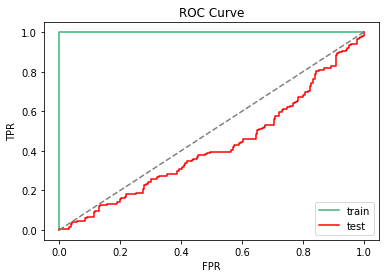

In [ ]:
# logistic regression + count vectorizer 

# training the model 
lrCV_Model = LogisticRegression()
lrCV_Model.fit(X_train_countVectorized, y_train)

# prediction 
lrCV_Train = lrCV_Model.predict(X_train_countVectorized)
lrCV_Pred = lrCV_Model.predict(X_test_countVectorized)
lrCV_Accu = accuracy_score(y_test, lrCV_Pred)
print("the accuracy score of the benchmark model using uni-gram count vectorizer is: {:2.3f}".format(lrCV_Accu))

# ROC and AUC
auc_lrCV = roc_auc_score(y_test, lrCV_Pred)
F1_lrCV = f1_score(y_test, lrCV_Pred)

print("The AUC Score is: {:2.3f}".format(auc_lrCV))
print("The F1 score is: {:2.3f}".format(F1_lrCV))
print("="*50)
print("The confusion matrix is:")
print(classification_report(y_test, lrCV_Pred))
print("="*50)

X_pred = lrCV_Model.predict_proba(X_train_countVectorized)[:, 1]
y_pred = lrCV_Model.predict_proba(X_test_countVectorized)[:, 1]
plot_roc(X_pred, y_train, y_pred, y_test)

the accuracy score of the benchmark model using 2-gram count vectorizer is: 0.563
The AUC Score is: 0.560
The F1 score is: 0.636
The confusion matrix is:
              precision    recall  f1-score   support

           0       0.59      0.37      0.46       186
           1       0.55      0.75      0.64       192

    accuracy                           0.56       378
   macro avg       0.57      0.56      0.55       378
weighted avg       0.57      0.56      0.55       378



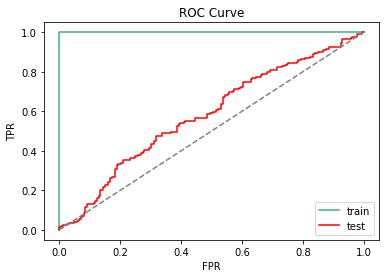

In [ ]:
# logistic regression + bi-gram (2 only) count vectorizer 

# training the model 
lrCV2_Model = LogisticRegression()
lrCV2_Model.fit(X_train_biCountVectorized, y_train)

# prediction 
lrCV2_Train = lrCV2_Model.predict(X_train_biCountVectorized)
lrCV2_Pred = lrCV2_Model.predict(X_test_biCountVectorized)
lrCV2_Accu = accuracy_score(y_test, lrCV2_Pred)
print("the accuracy score of the benchmark model using 2-gram count vectorizer is: {:2.3f}".format(lrCV2_Accu))

# ROC and AUC
auc_lrCV2 = roc_auc_score(y_test, lrCV2_Pred)
F1_lrCV2 = f1_score(y_test, lrCV2_Pred)

print("The AUC Score is: {:2.3f}".format(auc_lrCV2))
print("The F1 score is: {:2.3f}".format(F1_lrCV2))
print("="*50)
print("The confusion matrix is:")
print(classification_report(y_test, lrCV2_Pred))
print("="*50)

X_pred = lrCV2_Model.predict_proba(X_train_biCountVectorized)[:, 1]
y_pred = lrCV2_Model.predict_proba(X_test_biCountVectorized)[:, 1]
plot_roc(X_pred, y_train, y_pred, y_test)

the accuracy score of the benchmark model using 3-gram count vectorizer is: 0.511
The AUC Score is: 0.503
The F1 score is: 0.670
The confusion matrix is:
              precision    recall  f1-score   support

           0       0.56      0.03      0.05       186
           1       0.51      0.98      0.67       192

    accuracy                           0.51       378
   macro avg       0.53      0.50      0.36       378
weighted avg       0.53      0.51      0.37       378



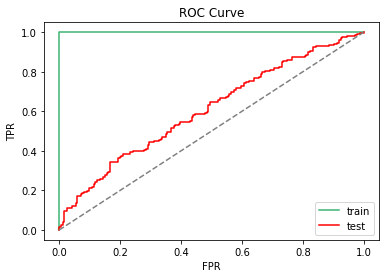

In [ ]:
# logistic regression + tri-gram (3 only) count vectorizer 

# training the model 
lrCV3_Model = LogisticRegression()
lrCV3_Model.fit(X_train_triCountVectorized, y_train)

# prediction 
lrCV3_Train = lrCV3_Model.predict(X_train_triCountVectorized)
lrCV3_Pred = lrCV3_Model.predict(X_test_triCountVectorized)
lrCV3_Accu = accuracy_score(y_test, lrCV3_Pred)
print("the accuracy score of the benchmark model using 3-gram count vectorizer is: {:2.3f}".format(lrCV3_Accu))

# ROC and AUC
auc_lrCV3 = roc_auc_score(y_test, lrCV3_Pred)
F1_lrCV3 = f1_score(y_test, lrCV3_Pred)

print("The AUC Score is: {:2.3f}".format(auc_lrCV3))
print("The F1 score is: {:2.3f}".format(F1_lrCV3))
print("="*50)
print("The confusion matrix is:")
print(classification_report(y_test, lrCV3_Pred))
print("="*50)

X_pred = lrCV3_Model.predict_proba(X_train_triCountVectorized)[:,1]
y_pred = lrCV3_Model.predict_proba(X_test_triCountVectorized)[:,1]
plot_roc(X_pred, y_train, y_pred, y_test)

the accuracy score of the benchmark model using default tfidf is: 0.489
The AUC Score is: 0.482
The F1 score is: 0.647
The confusion matrix is:
              precision    recall  f1-score   support

           0       0.35      0.04      0.08       186
           1       0.50      0.92      0.65       192

    accuracy                           0.49       378
   macro avg       0.42      0.48      0.36       378
weighted avg       0.42      0.49      0.37       378



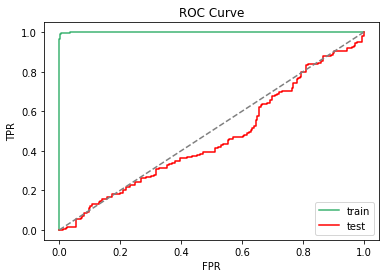

In [ ]:
# logistic regression + default tfidf 

# training the model 
lrTFIDF_Model = LogisticRegression()
lrTFIDF_Model.fit(X_train_tfidf, y_train)

# prediction 
lrTFIDF_Train = lrTFIDF_Model.predict(X_train_tfidf)
lrTFIDF_Pred = lrTFIDF_Model.predict(X_test_tfidf)
lrTFIDF_Accu = accuracy_score(y_test, lrTFIDF_Pred)
print("the accuracy score of the benchmark model using default tfidf is: {:2.3f}".format(lrTFIDF_Accu))

# ROC and AUC
auc_lrTFIDF = roc_auc_score(y_test, lrTFIDF_Pred)
F1_lrTFIDF = f1_score(y_test, lrTFIDF_Pred)

print("The AUC Score is: {:2.3f}".format(auc_lrTFIDF))
print("The F1 score is: {:2.3f}".format(F1_lrTFIDF))
print("="*50)
print("The confusion matrix is:")
print(classification_report(y_test, lrTFIDF_Pred))
print("="*50)

X_pred = lrTFIDF_Model.predict_proba(X_train_tfidf)[:,1]
y_pred = lrTFIDF_Model.predict_proba(X_test_tfidf)[:,1]
plot_roc(X_pred, y_train, y_pred, y_test)

the accuracy score of the benchmark model using 2-gram tfidf is: 0.508
The AUC Score is: 0.500
The F1 score is: 0.674
The confusion matrix is:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.51      1.00      0.67       192

    accuracy                           0.51       378
   macro avg       0.25      0.50      0.34       378
weighted avg       0.26      0.51      0.34       378



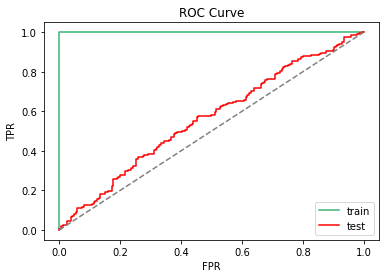

In [ ]:
# logistic regression + tfidf 2-gram

# training the model 
lrTFIDF2_Model = LogisticRegression()
lrTFIDF2_Model.fit(X_train_tfidf2, y_train)

# prediction 
lrTFIDF2_Train = lrTFIDF2_Model.predict(X_train_tfidf2)
lrTFIDF2_Pred = lrTFIDF2_Model.predict(X_test_tfidf2)
lrTFIDF2_Accu = accuracy_score(y_test, lrTFIDF2_Pred)
print("the accuracy score of the benchmark model using 2-gram tfidf is: {:2.3f}".format(lrTFIDF2_Accu))

# ROC and AUC
auc_lrTFIDF2 = roc_auc_score(y_test, lrTFIDF2_Pred)
F1_lrTFIDF2 = f1_score(y_test, lrTFIDF2_Pred)

print("The AUC Score is: {:2.3f}".format(auc_lrTFIDF2))
print("The F1 score is: {:2.3f}".format(F1_lrTFIDF2))
print("="*50)
print("The confusion matrix is:")
print(classification_report(y_test, lrTFIDF2_Pred))
print("="*50)

X_pred = lrTFIDF2_Model.predict_proba(X_train_tfidf2)[:,1]
y_pred = lrTFIDF2_Model.predict_proba(X_test_tfidf2)[:,1]
plot_roc(X_pred, y_train, y_pred, y_test)

the accuracy score of the benchmark model using 3-gram tfidf is: 0.508
The AUC Score is: 0.500
The F1 score is: 0.674
The confusion matrix is:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.51      1.00      0.67       192

    accuracy                           0.51       378
   macro avg       0.25      0.50      0.34       378
weighted avg       0.26      0.51      0.34       378



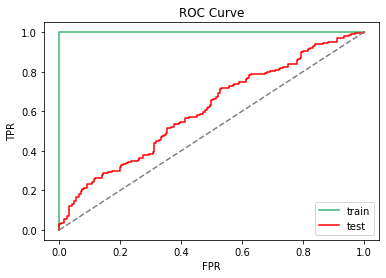

In [ ]:
# logistic regression + tfidf 3-gram

# training the model 
lrTFIDF3_Model = LogisticRegression()
lrTFIDF3_Model.fit(X_train_tfidf3, y_train)

# prediction 
lrTFIDF3_Train = lrTFIDF3_Model.predict(X_train_tfidf3)
lrTFIDF3_Pred = lrTFIDF3_Model.predict(X_test_tfidf3)
lrTFIDF3_Accu = accuracy_score(y_test, lrTFIDF3_Pred)
print("the accuracy score of the benchmark model using 3-gram tfidf is: {:2.3f}".format(lrTFIDF3_Accu))

# ROC and AUC
auc_lrTFIDF3 = roc_auc_score(y_test, lrTFIDF3_Pred)
F1_lrTFIDF3 = f1_score(y_test, lrTFIDF3_Pred)

print("The AUC Score is: {:2.3f}".format(auc_lrTFIDF3))
print("The F1 score is: {:2.3f}".format(F1_lrTFIDF3))
print("="*50)
print("The confusion matrix is:")
print(classification_report(y_test, lrTFIDF3_Pred))
print("="*50)

X_pred = lrTFIDF3_Model.predict_proba(X_train_tfidf3)[:,1]
y_pred = lrTFIDF3_Model.predict_proba(X_test_tfidf3)[:,1]
plot_roc(X_pred, y_train, y_pred, y_test)

the accuracy score of the benchmark model using customised setting tfidf is: 0.569
The AUC Score is: 0.566
The F1 score is: 0.629
The confusion matrix is:
              precision    recall  f1-score   support

           0       0.59      0.41      0.49       186
           1       0.56      0.72      0.63       192

    accuracy                           0.57       378
   macro avg       0.57      0.57      0.56       378
weighted avg       0.57      0.57      0.56       378



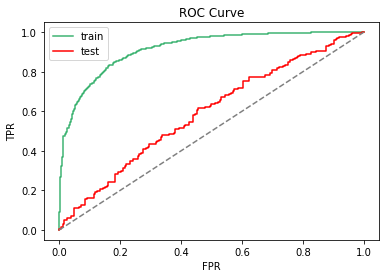

In [ ]:
# logistic regression + customized tfidf 

# training the model 
lrTFIDF4_Model = LogisticRegression()
lrTFIDF4_Model.fit(X_train_tfidf4, y_train)

# prediction 
lrTFIDF4_Train = lrTFIDF4_Model.predict(X_train_tfidf4)
lrTFIDF4_Pred = lrTFIDF4_Model.predict(X_test_tfidf4)
lrTFIDF4_Accu = accuracy_score(y_test, lrTFIDF4_Pred)
print("the accuracy score of the benchmark model using customised setting tfidf is: {:2.3f}".format(lrTFIDF4_Accu))

# ROC and AUC
auc_lrTFIDF4 = roc_auc_score(y_test, lrTFIDF4_Pred)
F1_lrTFIDF4 = f1_score(y_test, lrTFIDF4_Pred)

print("The AUC Score is: {:2.3f}".format(auc_lrTFIDF4))
print("The F1 score is: {:2.3f}".format(F1_lrTFIDF4))
print("="*50)
print("The confusion matrix is:")
print(classification_report(y_test, lrTFIDF4_Pred))
print("="*50)

X_pred = lrTFIDF4_Model.predict_proba(X_train_tfidf4)[:,1]
y_pred = lrTFIDF4_Model.predict_proba(X_test_tfidf4)[:,1]
plot_roc(X_pred, y_train, y_pred, y_test)

### Random Forest

the accuracy score of the default random forest model with 2-gram count vectorizer is: 0.508
The AUC Score is: 0.500
The F1 score is: 0.668
The confusion matrix is:
              precision    recall  f1-score   support

           0       0.50      0.03      0.05       186
           1       0.51      0.97      0.67       192

    accuracy                           0.51       378
   macro avg       0.50      0.50      0.36       378
weighted avg       0.50      0.51      0.36       378



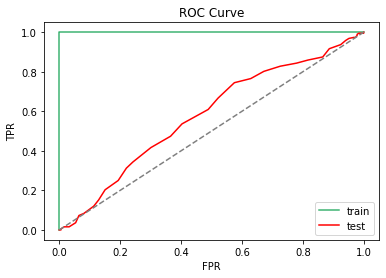

In [ ]:
# random forest with default settings + 2-gram count vectorizer

# training the model 
rfCV_Model = RandomForestClassifier(random_state = random_state)
rfCV_Model.fit(X_train_biCountVectorized, y_train)

# prediction
rfCV_Train = rfCV_Model.predict(X_train_biCountVectorized)
rfCV_Pred = rfCV_Model.predict(X_test_biCountVectorized)
rfCV_Accu = accuracy_score(y_test, rfCV_Pred)
print("the accuracy score of the default random forest model with 2-gram count vectorizer is: {:2.3f}".format(rfCV_Accu))

# ROC and AUC
auc_rfCV = roc_auc_score(y_test, rfCV_Pred)
F1_rfCV = f1_score(y_test, rfCV_Pred)

print("The AUC Score is: {:2.3f}".format(auc_rfCV))
print("The F1 score is: {:2.3f}".format(F1_rfCV))
print("="*50)
print("The confusion matrix is:")
print(classification_report(y_test, rfCV_Pred))
print("="*50)

X_pred = rfCV_Model.predict_proba(X_train_biCountVectorized)[:,1]
y_pred = rfCV_Model.predict_proba(X_test_biCountVectorized)[:,1]
plot_roc(X_pred, y_train, y_pred, y_test)

the accuracy score of the default random forest model with customized tfidf is: 0.524
The AUC Score is: 0.523
The F1 score is: 0.550
The confusion matrix is:
              precision    recall  f1-score   support

           0       0.52      0.47      0.49       186
           1       0.53      0.57      0.55       192

    accuracy                           0.52       378
   macro avg       0.52      0.52      0.52       378
weighted avg       0.52      0.52      0.52       378



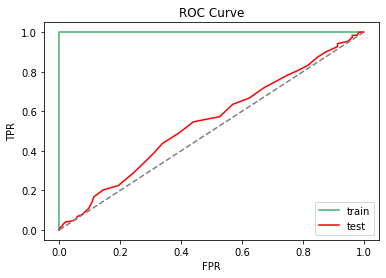

In [ ]:
# random forest with default settings + customized tfidf

rfTFIDF_Model = RandomForestClassifier(random_state = random_state)
rfTFIDF_Model.fit(X_train_tfidf4, y_train)

rfTFIDF_Train = rfTFIDF_Model.predict(X_train_tfidf4)
rfTFIDF_Pred = rfTFIDF_Model.predict(X_test_tfidf4)
rfTFIDF_Accu = accuracy_score(y_test, rfTFIDF_Pred)
print("the accuracy score of the default random forest model with customized tfidf is: {:2.3f}".format(rfTFIDF_Accu))

# ROC and AUC
auc_rfTFIDF = roc_auc_score(y_test, rfTFIDF_Pred)
F1_rfTFIDF = f1_score(y_test, rfTFIDF_Pred)

print("The AUC Score is: {:2.3f}".format(auc_rfTFIDF))
print("The F1 score is: {:2.3f}".format(F1_rfTFIDF))
print("="*50)
print("The confusion matrix is:")
print(classification_report(y_test, rfTFIDF_Pred))
print("="*50)

X_pred = rfTFIDF_Model.predict_proba(X_train_tfidf4)[:,1]
y_pred = rfTFIDF_Model.predict_proba(X_test_tfidf4)[:,1]
plot_roc(X_pred, y_train, y_pred, y_test)

### AdaBoost 

the accuracy score of the default random forest model with customized tfidf is: 0.532
The AUC Score is: 0.529
The F1 score is: 0.599
The confusion matrix is:
              precision    recall  f1-score   support

           0       0.53      0.37      0.44       186
           1       0.53      0.69      0.60       192

    accuracy                           0.53       378
   macro avg       0.53      0.53      0.52       378
weighted avg       0.53      0.53      0.52       378



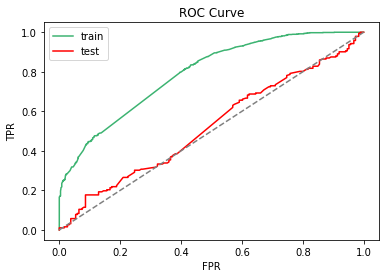

In [ ]:
# model
ada_clf = AdaBoostClassifier(random_state = random_state)
ada_clf.fit(X_train_tfidf4, y_train)

# prediction
ada_Train = ada_clf.predict(X_train_tfidf4)
ada_Pred  = ada_clf.predict(X_test_tfidf4)
ada_Accu  = accuracy_score(y_test, ada_Pred)
print("the accuracy score of the default random forest model with customized tfidf is: {:2.3f}".format(ada_Accu))

# ROC and AUC
auc_ada = roc_auc_score(y_test, ada_Pred)
F1_ada = f1_score(y_test, ada_Pred)

print("The AUC Score is: {:2.3f}".format(auc_ada))
print("The F1 score is: {:2.3f}".format(F1_ada))
print("="*50)
print("The confusion matrix is:")
print(classification_report(y_test, ada_Pred))
print("="*50)

X_pred = ada_clf.predict_proba(X_train_tfidf4)[:,1]
y_pred = ada_clf.predict_proba(X_test_tfidf4)[:,1]
plot_roc(X_pred, y_train, y_pred, y_test)

### XGBoost

the accuracy score of the default random forest model with customized tfidf is: 0.516
The AUC Score is: 0.513
The F1 score is: 0.594
The confusion matrix is:
              precision    recall  f1-score   support

           0       0.51      0.33      0.40       186
           1       0.52      0.70      0.59       192

    accuracy                           0.52       378
   macro avg       0.51      0.51      0.50       378
weighted avg       0.52      0.52      0.50       378



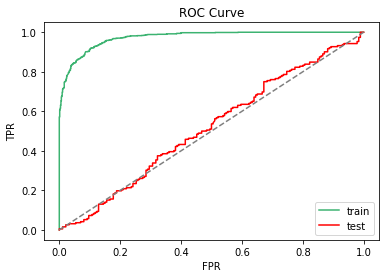

In [ ]:
# model
xgb_clf = XGBClassifier(random_state = random_state)
xgb_clf.fit(X_train_tfidf4, y_train)

# prediction
xgb_Train = xgb_clf.predict(X_train_tfidf4)
xgb_Pred  = xgb_clf.predict(X_test_tfidf4)
xgb_Accu  = accuracy_score(y_test, xgb_Pred)
print("the accuracy score of the default random forest model with customized tfidf is: {:2.3f}".format(xgb_Accu))

# ROC and AUC
auc_xgb = roc_auc_score(y_test, xgb_Pred)
F1_xgb = f1_score(y_test, xgb_Pred)

print("The AUC Score is: {:2.3f}".format(auc_xgb))
print("The F1 score is: {:2.3f}".format(F1_xgb))
print("="*50)
print("The confusion matrix is:")
print(classification_report(y_test, xgb_Pred))
print("="*50)

X_pred = xgb_clf.predict_proba(X_train_tfidf4)[:,1]
y_pred = xgb_clf.predict_proba(X_test_tfidf4)[:,1]
plot_roc(X_pred, y_train, y_pred, y_test)

# Part II: Word Embeddings and Deep Learning 

The flowchart of this part can be summarized as:

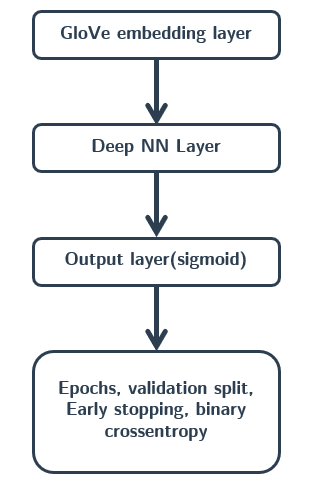


The following types are used for deep neural networks layer:

1. Recurrent layer
2. Convolutional layer
3. Hybrid (Convolutional layer and recurrent layer)

## GloVe Embeddings

In [ ]:
# create the GloVe embedding matrix 
nltk.download('punkt')
glove_matrix = {}

with open("drive/MyDrive/NLP/glove.6B.100d.txt", "r") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        glove_matrix[word] = vectors 

f.close()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# define constant values for GloVe embeddings 

# maximum length of each senetences 
MAX_LEN = 2500
# dimension of the embedding matrix 
EMBEDDING_DIM = 100

In [ ]:
# convert words to tokens and pad all sentences to the same length

# fit the tokenizer with training dataset 
tokenizer = Tokenizer(oov_token = "OOV")
tokenizer.fit_on_texts(X_train)

# convert texts to tokens 
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN)

print("Number of unique words: ", len(tokenizer.word_index))

Number of unique words:  34181


In [ ]:
# map the GloVe embedding matrix 

num_words = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM)) 
for word, i in tokenizer.word_index.items():
    if i < num_words:
        emb_vec = glove_matrix.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

## Deep Learning

### LSTM

The structure of the LSTM network

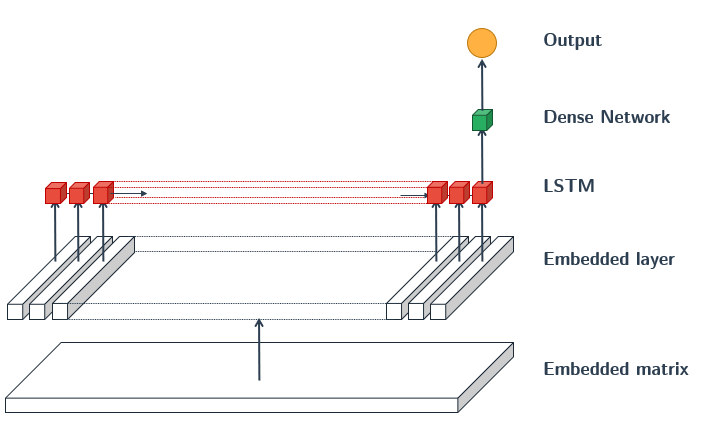

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2500, 100)         3418200   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,498,701
Trainable params: 80,501
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/10
46/46 [==============================] - 84s 2s/step - loss: 0.7030 - accuracy: 0.5185 - val_loss: 0.6883 - val_accuracy: 0.5802
Epoch 2/10
46/46 [==============================] - 82s 2s/step - loss: 0.6838 - accuracy: 0.5600 - val_loss: 0.6981 - val_accuracy: 0.5123
Epoch 3/10
46/46 [==============================] - 81s 2s/step - loss: 0.6674 - accur

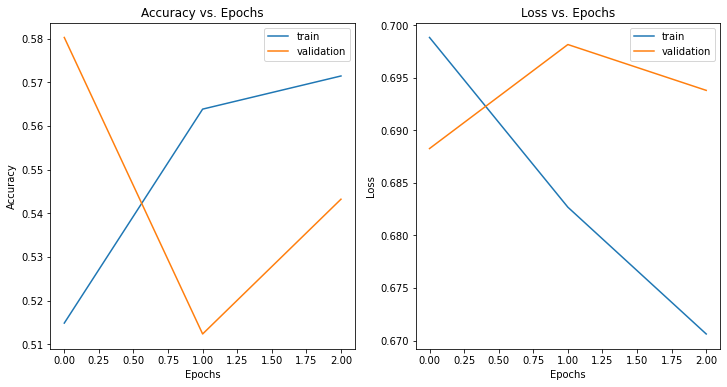

In [ ]:
# training RNN with default settings using GloVe (Adam)

from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(LSTM(100))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 3,498,701
Trainable params: 80,501
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/10
46/46 [==============================] - 84s 2s/step - loss: 0.7223 - accuracy: 0.4957 - val_loss: 0.6833 - val_accuracy: 0.5370
Epoch 2/10
46/46 [==============================] - 82s 2s/step - loss: 0.6704 - accuracy: 0.6091 - val_loss: 0.6969 - val_accuracy: 0.5123
Epoch 3/10
46/46 [==============================] - 85s 2s/step - loss: 0.6390 - acc

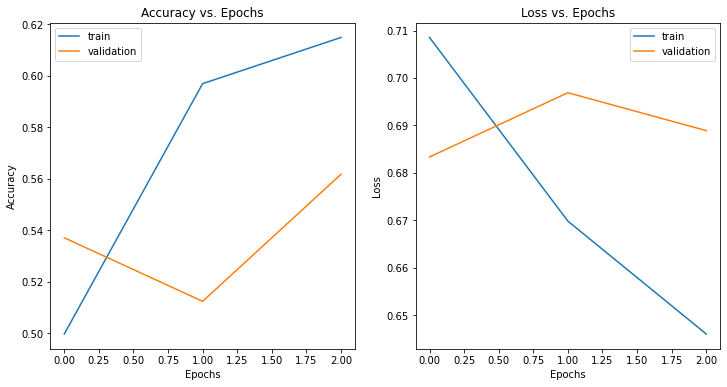

In [ ]:
# increase learning rate 

from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(LSTM(100))
model.add(Dense(1, activation = "sigmoid"))

optimizer = Adam(learning_rate = 0.005)

# compile the model
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["accuracy"])
# print out model summary
print(model.summary())

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 3,498,701
Trainable params: 80,501
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/10
46/46 [==============================] - 92s 2s/step - loss: 0.7124 - accuracy: 0.4639 - val_loss: 0.7053 - val_accuracy: 0.4815
Epoch 2/10
46/46 [==============================] - 89s 2s/step - loss: 0.6849 - accuracy: 0.5681 - val_loss: 0.6912 - val_accuracy: 0.5494
Epoch 3/10
46/46 [==============================] - 92s 2s/step - loss: 0.6639 - acc

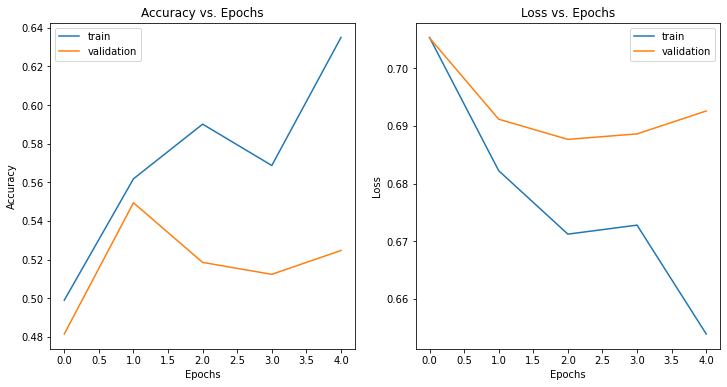

In [ ]:
# adding dropout 
 
from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(LSTM(100, dropout=0.2))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,498,701
Trainable params: 80,501
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/10
46/46 [==============================] - 224s 5s/step - loss: 0.6982 - accuracy: 0.5160 - val_loss: 0.7175 - val_accuracy: 0.4012
Epoch 2/10
46/46 [==============================] - 220s 5s/step - loss: 0.6878 - accuracy: 0.5531 - val_loss: 0.6868 - val_accuracy: 0.5617
Epoch 3/10
46/46 [==============================] - 220s 5s/step - loss: 0.6704 - 

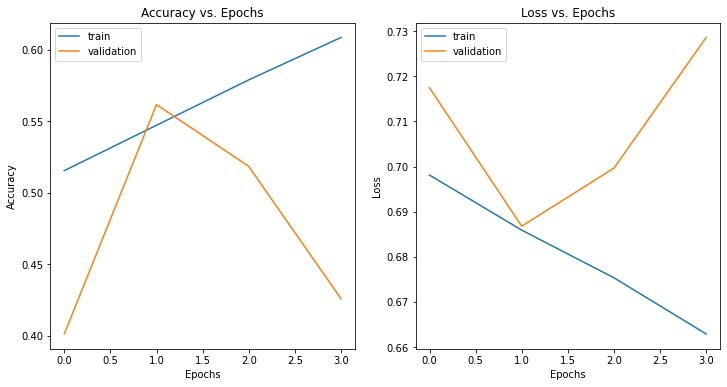

In [ ]:
# adding dropout & recurrent dropout 
 
from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(LSTM(100, dropout=0.2, recurrent_dropout = 0.2))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 2500, 100)         80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 3,579,101
Trainable params: 160,901
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/10
12/12 [==============================] - 156s 13s/step - loss: 0.7022 - accuracy: 0.4745 - val_loss: 0.6851 - val_accuracy: 0.5926
Epoch 2/10
12/12 [==============================] - 154s 13s/step - loss: 0.6867 - accura

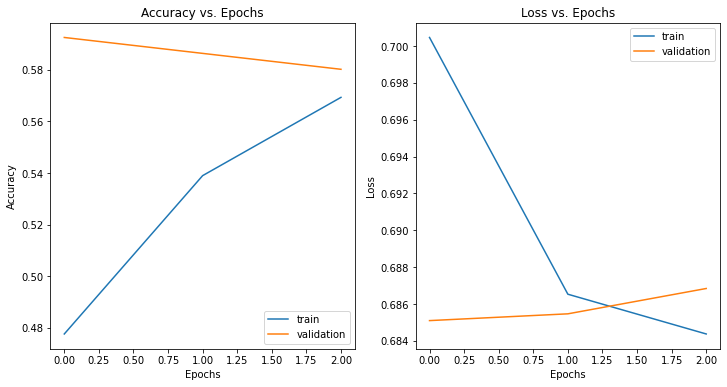

In [ ]:
# stack two LSTM and specify batch size 

from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
optimizer = Adam(learning_rate = 0.001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["accuracy"])
# print out model summary
print(model.summary())

batch_size = 128

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)],
                    batch_size=batch_size)

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 3,498,701
Trainable params: 80,501
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/10
46/46 [==============================] - 84s 2s/step - loss: 0.7048 - accuracy: 0.5069 - val_loss: 0.6960 - val_accuracy: 0.5062
Epoch 2/10
46/46 [==============================] - 82s 2s/step - loss: 0.6794 - accuracy: 0.5744 - val_loss: 0.6948 - val_accuracy: 0.5247
Epoch 3/10
46/46 [==============================] - 90s 2s/step - loss: 0.6691 - acc

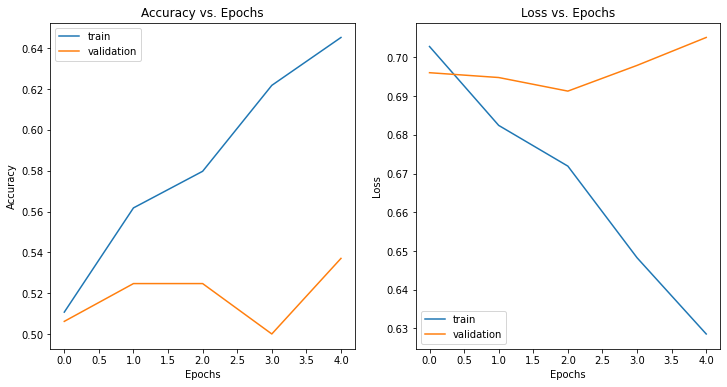

In [ ]:
# use Nadam as optimizer 

from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Nadam


model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(LSTM(100))
model.add(Dense(1, activation = "sigmoid"))

optimizer = Nadam()

# compile the model
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["accuracy"])
# print out model summary
print(model.summary())

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

### GRU

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 2500, 100)         3418200   
_________________________________________________________________
gru_4 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 3,478,901
Trainable params: 60,701
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/10
46/46 [==============================] - 84s 2s/step - loss: 0.7120 - accuracy: 0.5102 - val_loss: 0.6947 - val_accuracy: 0.4938
Epoch 2/10
46/46 [==============================] - 85s 2s/step - loss: 0.6818 - accuracy: 0.5694 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 3/10
46/46 [==============================] - 88s 2s/step - loss: 0.6602 - ac

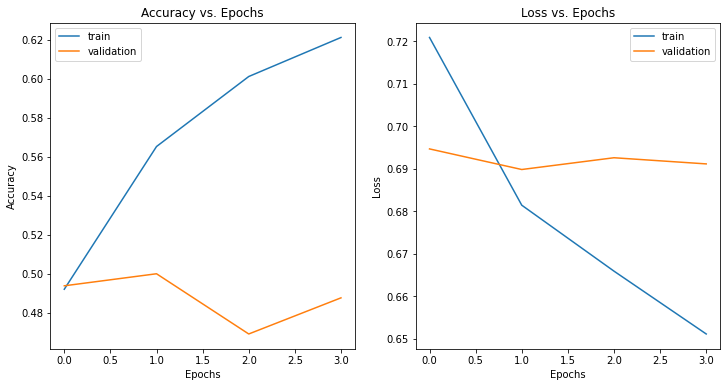

In [ ]:
# training RNN with GRU default settings using GloVe (Adam)

from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(GRU(100))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 3,478,901
Trainable params: 60,701
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/10
46/46 [==============================] - 82s 2s/step - loss: 0.7080 - accuracy: 0.5203 - val_loss: 0.7040 - val_accuracy: 0.4877
Epoch 2/10
46/46 [==============================] - 80s 2s/step - loss: 0.6819 - accuracy: 0.5567 - val_loss: 0.7010 - val_accuracy: 0.5000
Epoch 3/10
46/46 [==============================] - 80s 2s/step - loss: 0.6583 - ac

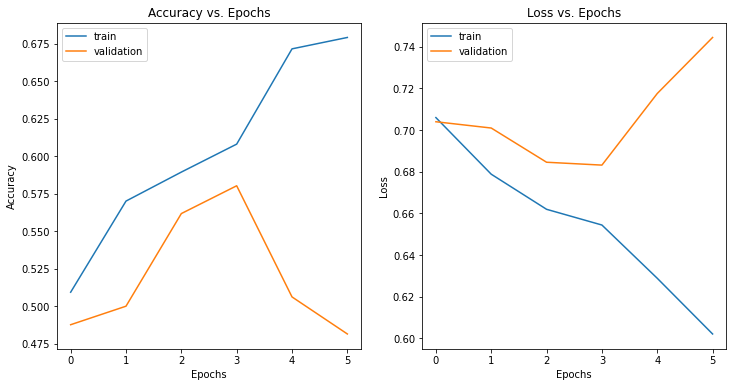

In [ ]:
# training RNN with GRU default settings using GloVe (Nadam)

from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from keras.callbacks import EarlyStopping
from keras.optimizers import Nadam

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(GRU(100))
model.add(Dense(1, activation = "sigmoid"))

optimizer = Nadam()

# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

### CNN

The structure of CNN

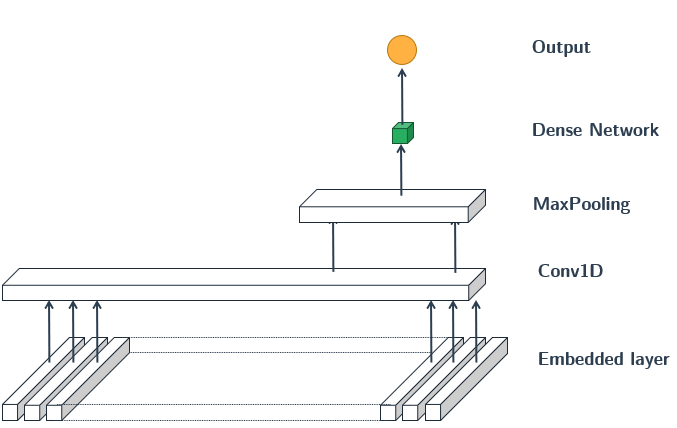

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
conv1d (Conv1D)              (None, 2500, 32)          16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1250, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               10000250  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 251       
Total params: 13,434,733
Trainable params: 10,016,533
Non-trainable params: 3,418,200
__________________________________

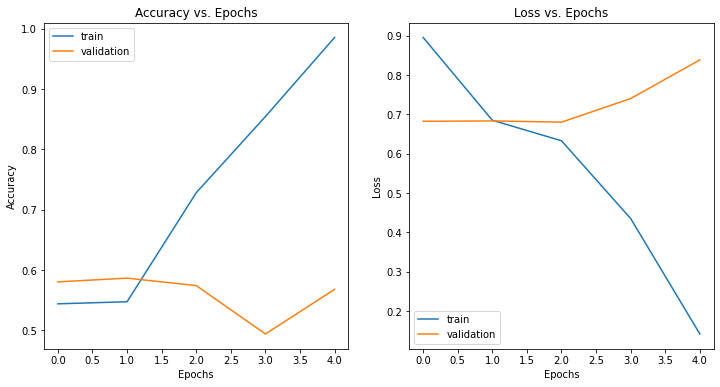

In [ ]:
# training CNN

from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, MaxPooling1D, Conv1D, Flatten
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2500, 64)          32064     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1250, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 250)               20000250  
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 251       
Total params: 23,450,765
Trainable params: 20,032,565
Non-trainable params: 3,418,200
__________________________________

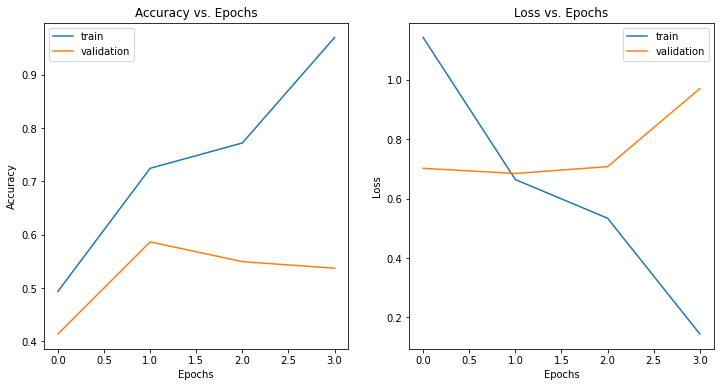

In [ ]:
# training CNN
# filters = 64

from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2500, 100)         3418200   
_________________________________________________________________
conv1d (Conv1D)              (None, 2500, 100)         50100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1250, 100)         0         
_________________________________________________________________
flatten (Flatten)            (None, 125000)            0         
_________________________________________________________________
dense (Dense)                (None, 250)               31250250  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 34,718,801
Trainable params: 31,300,601
Non-trainable params: 3,418,200
__________________________________

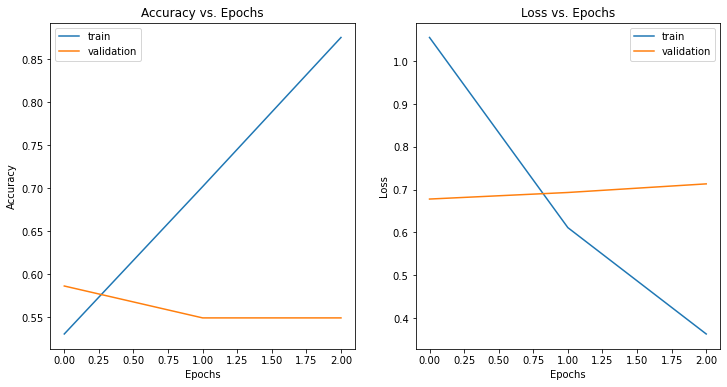

In [ ]:
# training CNN
# filters = 100

from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(Conv1D(filters=100, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2500, 32)          9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1250, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               10000250  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
Total params: 13,428,333
Trainable params: 10,010,133
Non-trainable params: 3,418,200
__________________________________

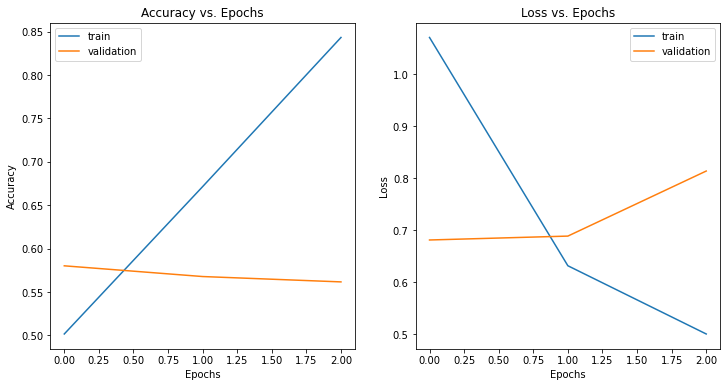

In [ ]:
# change kernel size

# training CNN

from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2500, 32)          6432      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1250, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 250)               10000250  
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 251       
Total params: 13,425,133
Trainable params: 10,006,933
Non-trainable params: 3,418,200
__________________________________

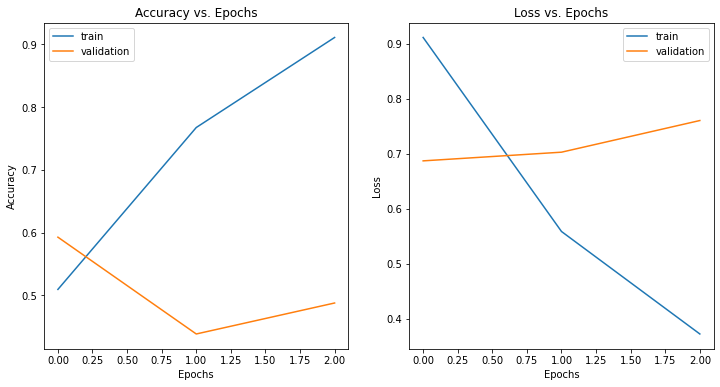

In [ ]:
# change kernel size = 2

# training CNN

from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

### CNN + RNN

The Structure of the network

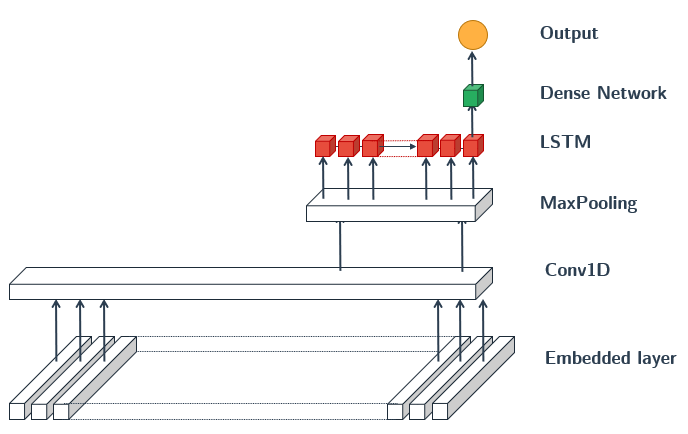

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
conv1d (Conv1D)              (None, 2500, 32)          16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1250, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 3,487,533
Trainable params: 69,333
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/10
12/12 [==============================] - 44s 3s/step - loss: 0.6975 - accuracy: 0.5193 - 

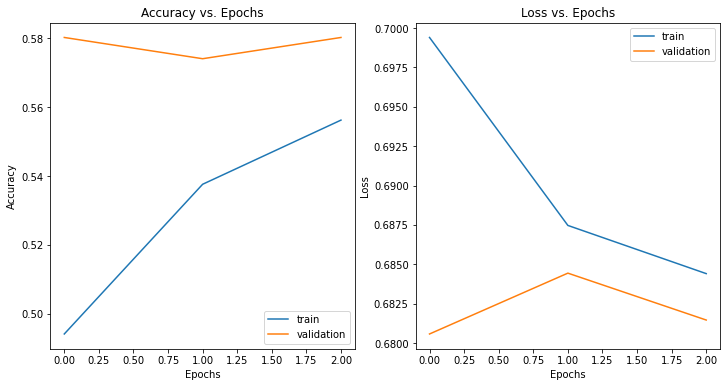

In [ ]:
# CNN + LSTM
from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
optimizer = Adam(learning_rate = 0.001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["accuracy"])
# print out model summary
print(model.summary())

batch_size = 128

history = model.fit(train_padded, y_train, epochs=10, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)],
                    batch_size=batch_size)

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2500, 10)          5010      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1250, 10)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               33600     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 3,456,911
Trainable params: 38,711
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/20
12/12 [==============================] - 36s 3s/step - loss: 0.6933 - accuracy: 0.5287 - 

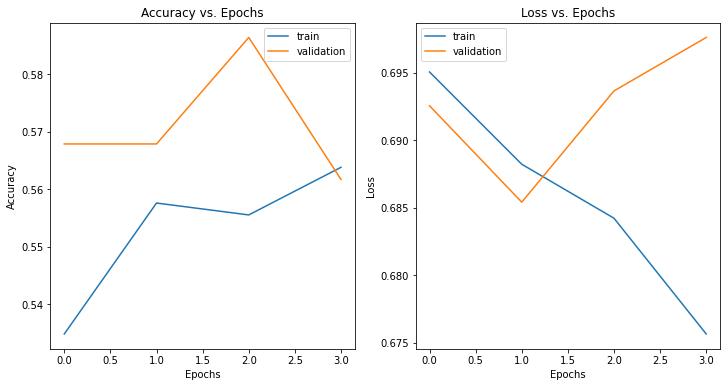

In [ ]:
# CNN+GRU
from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GRU
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(Conv1D(filters=10, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(100))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
# optimizer = SGD(learning_rate = 3e-4, momentum=0.9)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

batch_size = 128

history = model.fit(train_padded, y_train, epochs=20, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)],
                    batch_size=batch_size)

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2500, 32)          16032     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1250, 32)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 100)               40200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 3,474,533
Trainable params: 56,333
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/20
12/12 [==============================] - 39s 3s/step - loss: 0.7123 - accuracy: 0.4764 - 

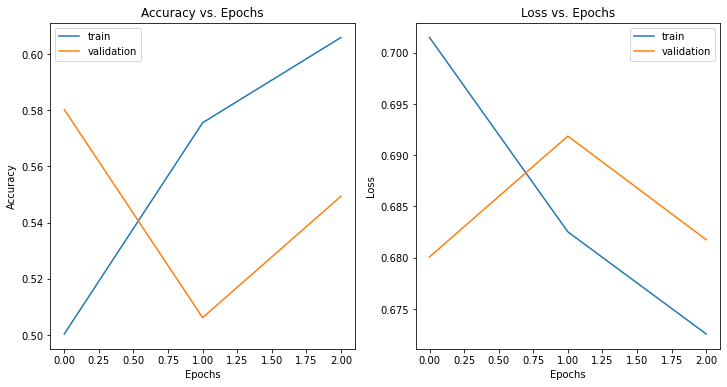

In [ ]:
# CNN+GRU
from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GRU
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(100))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
optimizer = Adam(learning_rate = 0.005)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

batch_size = 128

history = model.fit(train_padded, y_train, epochs=20, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)],
                    batch_size=batch_size)

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 2500, 100)         3418200   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2500, 10)          5010      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1250, 10)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               33600     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 3,456,911
Trainable params: 38,711
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/20
12/12 [==============================] - 36s 3s/step - loss: 0.6968 - accuracy: 0.5180 - 

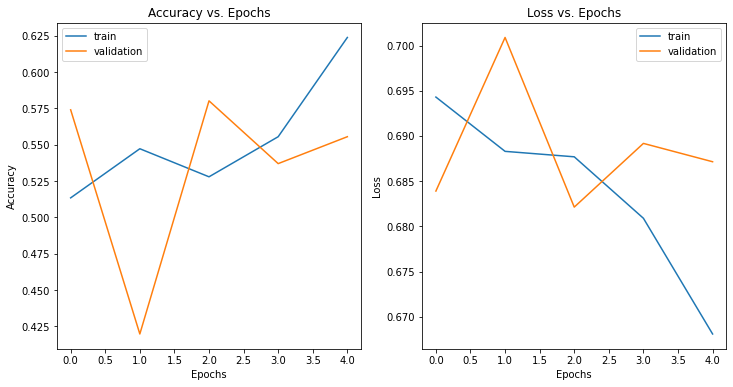

In [ ]:
# CNN+GRU
from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GRU
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(Conv1D(filters=10, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(100))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
optimizer = Adam(learning_rate = 0.005)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

batch_size = 128

history = model.fit(train_padded, y_train, epochs=20, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)],
                    batch_size=batch_size)

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 2500, 100)         3418200   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 2500, 10)          5010      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1250, 10)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 100)               33600     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 3,456,911
Trainable params: 38,711
Non-trainable params: 3,418,200
_________________________________________________________________
None
Epoch 1/20
12/12 [==============================] - 37s 3s/step - loss: 0.6925 - accuracy: 0.5507 -

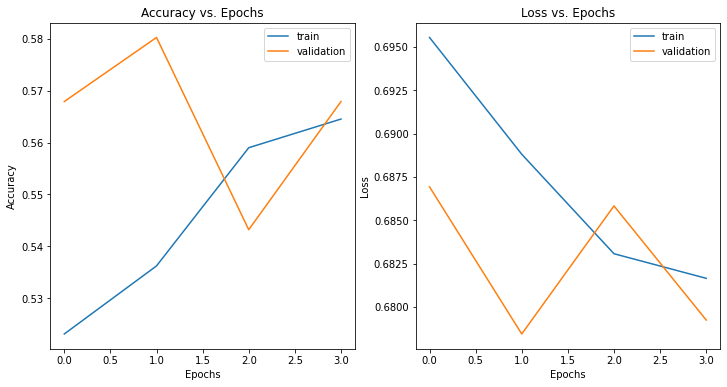

In [ ]:
# CNN+GRU
from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GRU
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD

model = Sequential()

model.add(
    Embedding(
        num_words,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable = False)
)
model.add(Conv1D(filters=10, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(100))
model.add(Dense(1, activation = "sigmoid"))

# compile the model
optimizer = Adam(learning_rate = 0.007)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
# print out model summary
print(model.summary())

batch_size = 128

history = model.fit(train_padded, y_train, epochs=20, validation_split=0.1, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)],
                    batch_size=batch_size)

scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: {:2.2f}%".format(scores[1]*100))

plot_history(history)

# Results

The overall results are summarised as follows:

## Machine Learning Results

- Best model: Linear Regression + customized Tfidf


|                     | uni-gram | bi-gram | tri-gram | Tfidf & uni-gram | Tfidf & bi-gram | Tfidf & tri-gram | customized Tfidf |
|---------------------|:--------:|:-------:|:--------:|:----------------:|:---------------:|:----------------:|:----------------:|
| Logistic regression |   0.429  |  0.563  |   0.511  |       0.489      |      0.508      |       0.508      |       0.569      |
| Random Forest       |     -    |  0.508  |     -    |         -        |        -        |         -        |       0.524      |
| AdaBoost            |     -    |    -    |     -    |         -        |        -        |         -        |       0.532      |
| XGBoost             |     -    |    -    |     -    |         -        |        -        |         -        |       0.516      |

From the ROC curve, significant overfitting was observed for all the n-gram approaches except for the customized Tfidf, hence, it is chosen for the remaining machine learning techniques. However, linear regression still has the best outcome. 

## Deep Learning Results

- Best model: CNN + GRU


|    Model   |                     Variants                     | Accuracy score |
|:----------:|:------------------------------------------------:|:--------------:|
| LSTM (RNN) | Default                                          | 0.5159         |
| LSTM (RNN) | learning rate = 0.005                            | 0.5238         |
| LSTM (RNN) | dropout = 0.2                                    | 0.5132         |
| LSTM (RNN) | dropout = 0.2, reccurent dropout = 0.2           | 0.4815         |
| LSTM (RNN) | 2 LSTM Layers                                    | 0.5132         |
| LSTM (RNN) | optimizer = Nadam                                | 0.4894         |
| GRU (RNN)  | Default                                          | 0.5026         |
| GRU (RNN)  | optimizer = Nadam                                | 0.4894         |
| CNN        | filters=32, kernel_size=5                        | 0.5079         |
| CNN        | filters=64, kernel_size=5                        | 0.4603         |
| CNN        | filters=100, kernel_size=5                       | 0.5            |
| CNN        | filters=32, kernel_size=3                        | 0.5026         |
| CNN        | filters=32, kernel_size=2                        | 0.4841         |
| CNN + LSTM | filters=32, kernel_size=5                        | 0.5079         |
| CNN + GRU  | filters=32, kernel_size=5                        | 0.5106         |
| CNN + GRU  | filters=32, kernel_size=5, learning_rate = 0.005 | 0.5            |
| CNN + GRU  | filters=10, kernel_size=5, learning_rate = 0.005 | 0.5265         |
| CNN + GRU  | filters=10, kernel_size=5, learning_rate = 0.007 | 0.4868         |

During the training, we observe that using convolutional neural networks drastically increase the training speed, unfortunately, we haven't seen any significant improvement on the performance. The baseline model using linear regression still outperforms all the machine learning and deep learning methods. 



# Conclusion 

In this project, the deep learning models has a lower performance than the baseline model (logistic regression) despite having a more complex structure, and the accuracy being very close to 50% implies that the result could well be a random guess. This may lead to a conclusion that the selected stock movement is independent from the selected news headlines. To check the validity of the model, I have also applied these models on a different dataset (IMDB movie reviews) and the accuracy score averages at about 88% without hyperparameter tuning, the models no longer suffer from overfitting despite being much larger. From the previous analysis using word clouds and topic modeling, it is clear that the main focus of these news are mainly international politics related to keywords such as the middle east, Russia, and China, which may have little impact on the Dow Jones stock index. 

In the future projects, the following can be tried:

- use a larger dataset, the current dataset has only over 1100 observations for training and validation set, and less than 400 observations for test set, which causes the model to overfit easily and difficult for generalization.
- use financial news and relevant stock prices. Other studeis have shown that using relevant financial news can indeed improve the result.  
- add lags into the result as the effect of the news may not show until the next day. Given the quality of the news itself, it is unlikely to see a boost in the result but it is worth trying. 



# Reference 

- Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow : concepts, tools, and techniques to build intelligent systems. Sebastopol, CA: O'Reilly Media. ISBN: 978-1491962299
- Lane, H., Howard, C., Hapke, H. (2019) Natural Language Processing in Action. Manning Publications. ISBN: 9781617294631
- Alzazah, Faten & Cheng, Xiaochun. (2020). Recent Advances in Stock Market Prediction Using Text Mining: A Survey. 10.5772/intechopen.92253. 